# Problem Set 4o: Neural Networks on Sequential Data

**Release Date:** 28 October

**Due Date:** 2 November

## Overview

We will learn the details of RNN/LSTM, as well as their applications to sequential data. In the first task, we will use an RNN to model and predict patterns in time-series data, specifically using sine wave. The second task focuses on a text classification, where we will employ LSTM network to classify reviews from movie reviews dataset as positive or negative.

**Required Files**:
* ps4o.ipynb
* data/
    * review_train.csv
    * review_test.csv

**Plagiarism Policy**: Please refer to our [Course Policies](https://canvas.nus.edu.sg/courses/62323/pages/course-policies).

**IMPORTANT**: While it is possible to write and run Python code directly in Jupyter notebook, we recommend that you do this Problem set with an IDE using the .py file provided. An IDE will make debugging significantly easier.

**Post-Problem Set Survey**:
Your feedback is important to us! After completing Problem Set 4o, please take a moment to share your thoughts by filling out this [survey](https://coursemology.org/courses/2851/surveys/2457).

### IMPORTANT

Your implementation in the following tasks **should not
involve any iteration, including `map` and `filter`, or recursion**.

## Packages
The necessary packages are imported in the cell below. Please make sure that you run this cell before proceeding

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(2109)
np.random.seed(2109)

: 

In [ ]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Simple RNN to Learn Sine Wave

In this task, you will create a simple RNN model to predict values of a sine wave based on prior inputs. The goal is for the RNN to learn the underlying pattern of the sine wave and use this understanding to predict unseen values in the sequence.

Through this exercies, you'll develop an understanding of how RNNs handle dependencies over time and how they can be trained to make predictions on continuous data.

### Task 1.1: RNN Cell

<center><img src="images/rnn.png" style="width:500px;height:300px"></center>

At the core of the RNN is the RNN cell, which processes one time step of the sequence at a time. For each time step, the cell updates its hidden state based on the current input and the previous hidden state.

We first implement the computations for a single time step. The diagram below describes the operations for a single time step of an RNN cell.
<center><img src="images/rnn_cell.png" style="width:700px;height:300px;"></center>

__Note__: an RNN cell outputs the hidden state $h_t$, but the function that you'll implement `rnn_cell_forward`, also calculates the prediction $\hat{y}_t$. Keep in mind that the activation functions within the RNN cell can be replaced with other activation functions. For this task, tanh and softmax are used, but they can be replaced by other activation functions as well.

In [ ]:
def rnn_cell_forward(xt, h_prev, Wxh, Whh, Why, bh, by):
    """
    Implements a single forward step of the RNN-cell

    Args:
        xt: 2D tensor of shape (nx, m)
            Input data at timestep "t"
        h_prev: 2D tensor of shape (nh, m)
            Hidden state at timestep "t-1"
        Wxh: 2D tensor of shape (nx, nh)
            Weight matrix multiplying the input
        Whh: 2D tensor of shape (nh, nh)
            Weight matrix multiplying the hidden state
        Why: 2D tensor of shape (nh, ny)
            Weight matrix relating the hidden-state to the output
        bh: 1D tensor of shape (nh, 1)
            Bias relating to next hidden-state
        by: 2D tensor of shape (ny, 1)
            Bias relating the hidden-state to the output

    Returns:
        yt_pred -- prediction at timestep "t", tensor of shape (ny, m)
        h_next -- next hidden state, of shape (nh, m)
    """
    """ YOUR CODE HERE """
    h_next = torch.tanh(Wxh.T @ xt + Whh.T @ h_prev + bh)
    yt_pred = torch.softmax(Why.T @ h_next + by, dim=0)
    print(yt_pred)
    return yt_pred, h_next
    """ YOUR CODE END HERE """

In [ ]:
# Test cases
public_paras = {
    'xt': torch.tensor([[1., 1., 2.], [2., 1., 3.], [3., 5., 3.]]),
    'h_prev': torch.tensor([[5., 3., 2.], [1., 3., 2.]]),
    'Wxh': torch.tensor([[2., 2.], [3., 4.], [4., 3.]]),
    'Whh': torch.tensor([[2., 4.], [2., 3.]]),
    'Why': torch.tensor([[3., 5.], [5., 4.]]),
    'bh': torch.tensor([[1.], [2.]]),
    'by': torch.tensor([[3.], [1.]]),
}

expected_yt_pred = torch.tensor([[0.7311, 0.7311, 0.7311], [0.2689, 0.2689, 0.2689]])
expected_h_next = torch.tensor([[1., 1., 1.], [1., 1., 1.]])

actual_yt_pred, actual_h_next = rnn_cell_forward(**public_paras)
assert torch.allclose(actual_yt_pred, expected_yt_pred, atol=1e-4)
assert torch.allclose(actual_h_next, expected_h_next, atol=1e-4)

tensor([[0.7311, 0.7311, 0.7311],
        [0.2689, 0.2689, 0.2689]])


### Task 1.2: Generate Sine Wave Data

Use torch.linspace(start, end, steps) to create a sequence of evenly spaced values between 0 and $8\pi$ over `num_time_steps` intervals. This will serve as the x-values (time points) for the sine wave.

In [ ]:
def generate_sine_wave(num_time_steps):
    """
    Generates a sine wave data

    Args:
        num_time_steps: int
            Number of time steps
    Returns:
        data: 1D tensor of shape (num_time_steps,)
            Sine wave data with corresponding time steps
    """
    """ YOUR CODE HERE """
    return torch.linspace(0, 8*np.pi, num_time_steps).sin()
    """ YOUR CODE END HERE """

In [ ]:
# Test cases
num_time_steps_public = 5
expected_data_public = torch.tensor([0.0000e+00, 1.7485e-07, 3.4969e-07, 4.7700e-08, 6.9938e-07])
actual_data = generate_sine_wave(num_time_steps_public)

assert torch.allclose(actual_data, expected_data_public)

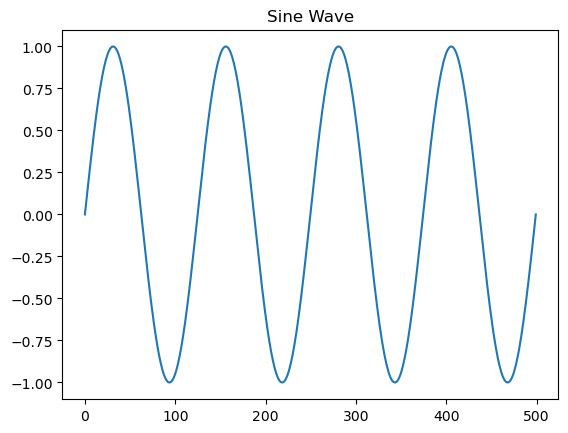

In [ ]:
num_time_steps = 500
sine_wave_data = generate_sine_wave(num_time_steps)

# Plot the sine wave
plt.plot(sine_wave_data)
plt.title('Sine Wave')
plt.show()

### Task 1.3: Create sequences

When training RNN, it's common to divide time series data into overlapping windows. The label used for comparison is the next value in the sequence.

For example if we have series of $n$ data points and a window size of 3, the input sequences are $[x_1, x_2, x_3]$ to predict $x_4$, $[x_2, x_3, x_4]$ to predict $x_5$, $[x_3, x_4, x_5]$, to predict $x_6$, and so on.

You will implement function `create_sequences` which generates sequences and their corresponding labels from a given sine wave.

In [ ]:
def create_sequences(sine_wave, seq_length):
    """
    Create overlapping sequences from the input time series and generate labels 
    Each label is the value immediately following the corresponding sequence.
    
    Args:
        sine_wave: A 1D tensor representing the time series data (e.g., sine wave).
        seq_length: int. The length of each sequence (window) to be used as input to the RNN.

    Returns: 
        windows: 2D tensor where each row is a sequence (window) of length `seq_length`.
        labels: 1D tensor where each element is the next value following each window.
    """
    """ YOUR CODE HERE """
    windows = sine_wave.unfold(0, seq_length, 1)[:-1]
    labels = sine_wave[seq_length:]
    return windows, labels
    """ YOUR CODE END HERE """

In [ ]:
# Test cases
seq_length_test = 2
sine_wave_test = torch.tensor([0., 1., 2., 3.])
expected_sequences = torch.tensor([[0., 1.], [1., 2.]])
expected_labels = torch.tensor([2., 3.])

actual_sequences, actual_labels = create_sequences(sine_wave_test, seq_length_test)
assert torch.allclose(actual_sequences, expected_sequences)
assert torch.allclose(actual_labels, expected_labels)

In [ ]:
# Create sequences and labels
seq_length = 20
sequences, labels = create_sequences(sine_wave_data, seq_length)
print(f"Shape of sequences: {sequences.shape}")
# Add extra dimension to match RNN input shape [batch_size, seq_length, num_features]
sequences = sequences.unsqueeze(-1)
sequences.shape

Shape of sequences: torch.Size([480, 20])


torch.Size([480, 20, 1])

In [ ]:
# Split the sequences into training data (first 80%) and test data (remaining 20%) 
train_size = int(len(sequences) * 0.8)
train_seqs, train_labels = sequences[:train_size], labels[:train_size]



test_seqs, test_labels = sequences[train_size:], labels[train_size:]
train_labels.shape


torch.Size([384])

### Task 1.4: Building RNN Model

Model Architecture
$$x \rightarrow \text{RNN} \rightarrow \text{Linear}(1)$$

- [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html): a basic recurrent layer in PyTorch. It takes an input of sequences and returns output for each time step, and the hidden state of the last time step. The `hidden_size` determines the number of hidden units in the RNN.
 
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): fully connected layer. The output from the RNN's last hidden state will be passed through this layer to predict a single value (the next time step in the series)

__Note:__ For all your networks hereon, the only constructor argument is `classes`. Do not add any other parameters to the `__init__` method. Remember not to hardcode and use the `classes` argument instead. For RNN layer, use `batch_first=True` to ensure that the batch dimension is handled as the first input dimension.

In [ ]:
class SineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize the SineRNN model.

        Args:
            input_size (int): The number of input features per time step (typically 1 for univariate time series).
            hidden_size (int): The number of units in the RNN's hidden layer.
            output_size (int): The size of the output (usually 1 for predicting a single value).
        """
        super(SineRNN, self).__init__()
        """ YOUR CODE HERE """
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        """ YOUR CODE END HERE """
        
    def forward(self, x):
        """ YOUR CODE HERE """
        output, _ = self.rnn(x) #dunnid ht since only 1 rnn layer
        output = self.fc(output)
        return output
        """ YOUR CODE END HERE """

In [ ]:
# Test cases
input_size = output_size = 1
hidden_size = 50
model = SineRNN(input_size, hidden_size, output_size)
assert [layer.detach().numpy().shape for _, layer in model.named_parameters()]\
      == [(50, 1), (50, 50), (50,), (50,), (1, 50), (1,)]

### Training

In [ ]:
# Define loss function, and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_seqs)
    loss = criterion(outputs.squeeze(1), train_labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [20/200], Loss: 0.508875
Epoch [40/200], Loss: 0.508875
Epoch [60/200], Loss: 0.508875
Epoch [80/200], Loss: 0.508875
Epoch [100/200], Loss: 0.508875
Epoch [120/200], Loss: 0.508875
Epoch [140/200], Loss: 0.508875
Epoch [160/200], Loss: 0.508875
Epoch [180/200], Loss: 0.508875
Epoch [200/200], Loss: 0.508875


### Evaluating

Once training is complete, we can evaluate the model by plotting its predictions against the actual sine wave. We use a portion of test data that the model hasn't seen during training to check how well it generalizes

In [ ]:
# Predict on unseen data
model.eval()
y_pred = []
input_seq = test_seqs[0]  # Start with the first testing sequence

with torch.no_grad():
    for _ in range(len(test_seqs)):
        output = model(input_seq)
        y_pred.append(output.detach().numpy()) 

        # Use the predicted value as the next input sequence
        next_seq = torch.cat((input_seq[1:, :], output.squeeze(0)), dim=0)
        input_seq = next_seq

# Plot the true sine wave and predictions
plt.plot(sine_wave_data, c='gray', label='Actual data')
plt.scatter(np.arange(seq_length + len(train_labels)), sine_wave_data[:seq_length + len(train_labels)], marker='.', label='Train')
x_axis_pred = np.arange(len(sine_wave_data) - len(test_labels), len(sine_wave_data))
plt.scatter(x_axis_pred, y_pred, marker='.', label='Predicted')
plt.legend(loc="lower left")
plt.show()

## 2. LSTM for Text Classification

Text classification in Natural Language Processing (NLP) involves automatically assigning predefined labels to textual data based on its content. It is a fundamental problem in NLP with a wide range of applications, including sentiment analysis, spam detection, and topic labeling, etc. The goal of text classification is to train a model that can learn patterns and features from labeled training data and use that knowledge to classify new, unseen text into predefined categories. These categories can be binary (e.g., positive/negative sentiment) or multiclass (e.g., sports, politics, entertainment).

In this task, we will train an LSTM-based sentiment classifier using IMDb movie reviews dataset.

### Task 2.1: LSTM Cell

The following figure shows the operations of an LSTM cell (Adopted from [Soure](https://d2l.ai/chapter_recurrent-modern/lstm.html#fig-lstm-3)).

<center><img src="images/lstm_cell.png" style="width:400;height:300px"></center>

where $\sigma$ is the sigmoid function and $\odot$ is the Hadamard product. 

Let $[\mathbf{H}_{t - 1}, \mathbf{X}_t\bigl]$ be the concatenation of hidden state $\mathbf{H}_{t - 1}$ and current time step's input $\mathbf{X}_t$, we have the equations for the forward pass of an LSTM cell as follows:

- **Forget Gate $\mathbf{F}_t$**: responsible for deciding which information is kept for calculating the cell state and which is not relevant and can be discarded
$$\mathbf{F}_{t} = \sigma\Bigl(\mathbf{W}_f\bigl[\mathbf{H}_{t - 1}, \mathbf{X}_t\bigl] + b_f\Bigl)$$
- **Input Gate $\mathbf{I}_t$**: updates the cell state and decides which information is important and which is not. As forget gate helps to discard the information, the input gate helps to find out important information and store certain data in the memory that relevant
$$\mathbf{I}_{t} = \sigma\Bigl(\mathbf{W}_i\bigl[\mathbf{H}_{t - 1}, \mathbf{X}_t\bigl] + b_i\Bigl)$$
- **Candidate $\tilde{\mathbf{C}}_t$**
$$\tilde{\mathbf{C}}_{t} = \tanh\Bigl(\mathbf{W}_c\bigl[\mathbf{H}_{t - 1}, \mathbf{X}_t\bigl] + b_c\Bigl)$$
- **Output Gate $\mathbf{O}_t$**: decides what the next hidden state should be
$$\mathbf{O}_{t} = \sigma\Bigl(\mathbf{W}_o\bigl[\mathbf{H}_{t - 1}, \mathbf{X}_t\bigl] + b_o\Bigl)$$
- **Memory Cell State $\mathbf{C}_t$**
$$\mathbf{C}_{t} = \mathbf{F}_t * \mathbf{C}_{t-1} + \mathbf{I}_t * \tilde{\mathbf{C}}_{t}$$
- **Hidden State $\mathbf{H}_t$**
$$\mathbf{H}_{t} = \mathbf{O}_t * \tanh\bigl(\mathbf{C}_{t}\bigl)$$

Similar to the RNN example, you'll begin by implementing the LSTM cell for a single time step.

In [ ]:
def lstm_cell_forward(xt, h_prev, c_prev, Wf, bf, Wi, bi, Wc, bc, Wo, bo):
    """
    Implement a single forward step of the LSTM cell

    Args:
        xt: 2D tensor of shape (nx, m)
            Input data at timestep "t"
        h_prev: 2D tensor of shape (nh, m)
            Hidden state at timestep "t-1"
        c_prev: 2D tensor of shape (nh, m)
            Memory state at timestep "t-1"
        Wf: tensor of shape(nh, nh + nx) 
            Weight matrix of the forget gate
        bf: tensor of shape (nh, 1)
            Bias of the forget gate
        Wi: tensor of shape (nh, nh + nx)
            Weight matrix of the input gate
        bi: tensor of shape (nh, 1)
            Bias of the input gate
        Wc: tensor of shape (nh, nh + nx)
            Weight matrix of candidate value
        bc: tensor of shape (nh, 1)
            Bias of the candidate value
        Wo: tensor of shape (nh, nh + nx)
            Weight matrix of the output gate
        bo: tensor of shape (nh, 1) 
            Bias of the output gate
    
    Returns:
        h_next: 2D tensor of shape (nh, m), next hidden state
        c_next: 2D tensor of shape (nh, m), next memory state
    """
    """ YOUR CODE HERE """
    concat = torch.cat((h_prev, xt), dim=0)
    ft = torch.sigmoid(Wf @ concat + bf)
    it = torch.sigmoid(Wi @ concat + bi)
    ct = torch.tanh(Wc @ concat + bc)
    c_next = ft * c_prev + it * ct
    ot = torch.sigmoid(Wo @ concat + bo)
    h_next = ot * torch.tanh(c_next)
    return h_next, c_next
    """ YOUR CODE END HERE """

In [ ]:
# Test cases
public_paras = {
    'xt': torch.tensor([[1.], [2.], [3.]]),
    'h_prev': torch.tensor([[1.], [2.]]),
    'c_prev': torch.tensor([[1.], [2.]]),
    'Wf': torch.tensor([[1., 1., 1., 1., 1.], [1., 1., 1., 1., 1.]]),
    'bf': torch.tensor([[1.], [1.]]),
    'Wi': torch.tensor([[1., 1., 1., 1., 1.], [1., 1., 1., 1., 1.]]),
    'bi': torch.tensor([[1.], [1.]]),
    'Wc': torch.tensor([[1., 1., 1., 1., 1.], [1., 1., 1., 1., 1.]]),
    'bc': torch.tensor([[1.], [1.]]),
    'Wo': torch.tensor([[1., 1., 1., 1., 1.], [1., 1., 1., 1., 1.]]),
    'bo': torch.tensor([[1.], [1.]])
}
expected_h_next = torch.tensor([[0.9640], [0.9950]])
expected_c_next = torch.tensor([[1.9999], [2.9999]])

actual_h_next, actual_c_next = lstm_cell_forward(**public_paras)
assert torch.allclose(actual_h_next, expected_h_next, atol=1e-4)
assert torch.allclose(actual_c_next, expected_c_next, atol=1e-4)

### Preparing Data

#### Sentence Polarity Dataset
The [Sentence Polarity Dataset](https://www.kaggle.com/datasets/nltkdata/sentence-polarity) is a widely used dataset for sentiment analysis and text classification tasks. The reviews are sampled from Rotten Tomatoes webpages and labeled with sentiment polarity, indicating whether the review expresses a positive or negative sentiment towards the movie.

In this task, we use a subset of the dataset consisting of 10,000 reviews, equally divided between 5,000 positive and 5,000 negative reviews. The dataset is pre-split into a training set with 8,000 reviews and a test set with 2,000 reviews. Each set maintains an even distribution of positive and negative reviews. The data is available at `data/` directory. The .csv files contain two columns: `review` and `label`, where 0 means the review is negative and 1 means the review is positive.

In [ ]:
# Load data from files
train_df = pd.read_csv('data/review_train.csv')
test_df = pd.read_csv('data/review_test.csv')
train_df.head(10)

,review,label
0,a reminder that beyond all the hype and recent...,1
1,jaglom . . . put[s] the audience in the privil...,1
2,if myers decides to make another austin powers...,0
3,""" bad "" is the operative word for "" bad compa...",0
4,"if you love the music , and i do , its hard to...",1
5,an awful lot like one of [spears'] music video...,0
6,bouquet gives a performance that is masterly .,1
7,there are a few stabs at absurdist comedy . . ...,1
8,harland williams is so funny in drag he should...,0
9,"creepy , authentic and dark . this disturbing ...",1


In [ ]:
train_df['label'].value_counts()

label
1    4000
0    4000
Name: count, dtype: int64

As we can see, the training dataset has 4,000 positive reviews (label = 1) and 4,000 negative reviews (label = 0).

#### Creating Dataset

In the previous PS, we used available datasets in PyTorch (MNIST, CIFAR) to train the networks. However, in this task, we will need to prepare the data ourselves. Using Dataset offers several advantages, including cleaner code and support for parallel processing on multiple CPUs or GPUs. It also optimizes data transfer between the CPU and GPU, which is crucial when working with large datasets. It is therefore the recommended best practice. 

We first create a simple `CustomDataset` which extends PyTorch's `Dataset`. This class only stores out inputs and targets. A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['review']
        label = self.data.iloc[idx]['label']
        return text, label

In [ ]:
train_dataset = CustomDataset('data/review_train.csv')
test_dataset = CustomDataset('data/review_test.csv')

In [ ]:
# Look at a sample review and label
idx = 28
print("Review: ", train_dataset.__getitem__(idx)[0])
print("Label: ", train_dataset.__getitem__(idx)[1])

Review:  what kids will discover is a new collectible . what parents will suspect is that they're watching a 76-minute commercial . 
Label:  0


#### Data processing pipelines

We will use `torchtext` package to simplify the process of preprocessing as it provides utilities and tools for working with text data. If you don't have it installed yet, you can install it using the following command.

In [ ]:
# ! pip install torchtext

The text pipeline is used to process the raw data strings from the dataset iterators. We need a tokenizer to divide text into individual units (call tokens) and a vocabulary which maps each unique token to a numerical index. The pipeline is then converts a text string into a list of integers based on the lookup table defined in the vocabulary.

Concepts:
- **Tokenization**: refers to the process of dividing a text or sentence into smaller components known as tokens. A token is often a individual word but can also be character, subword, or other meaningful element of text. Tokenization can present challenges, such as dealing with contractions (e.g., splitting "can't" into "can" and "'t") or punctuation ("Mr. Smith" treated as ["Mr", ".", "Smith"])
- **Special Tokens**:
    - `<pad>`: padding token, typically assigned the index 0. While training, a model we mostly train in batches. In a batch, there can be sentences of different length. So, we pad the shorter sentences with `<pad>` token to make length of all sequences in the batch equal.
    - `<unk>`: unknown token which is used when a model encounters a word it hasn't seen during training.

The following code demonstrates how to build a vocabulary from a dataset using tokenization and special tokens, and then transform text into a sequence of integers based on the vocabulary.

In [ ]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)


2.3.0
0.18.0+cpu


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english", language="en")
min_word_freq=2 # Words must appear at least twice to be included in the vocabulary
PAD_TOKEN = '<pad>' # padding token
UNK_TOKEN = '<unk>' # unknown token
SPECIALS = [PAD_TOKEN, UNK_TOKEN]

def build_vocab(dataset, tokenizer):
    texts = [text for text , _ in dataset]
    vocab = build_vocab_from_iterator(
        map(tokenizer, texts),
        specials=SPECIALS,
        min_freq=min_word_freq
    )
    vocab.set_default_index(vocab["<unk>"])
    return vocab

vocab = build_vocab(train_dataset,tokenizer)
vocab_size = vocab.__len__()
print("Vocabulary size: ", vocab_size)

Vocabulary size:  8459


In [ ]:
# The pipeline is a lambda function that takes an string x
# and applies two transformations: tokenize the input and then
# maps each token to its corresponding index from the vocabulary.
# 
# When the string 'Hello world!' is passed to the pipeline, 
# it is tokenized into ['hello', 'world', '!'].
# 
# The output [1, 167, 204] indicates that 'Hello' maps to index 1, 
# 'world' to 167, and '!' is mapped to index 204.
#  
# Because 1 is unknown token (<unk>), it suggests 'hello' is not in the vocabulary.
# In other words, 'hello' is not present in the training data.

pipeline = lambda x : vocab(tokenizer(x))
pipeline('Hello world!')

[1, 167, 204]

#### Collation

When working with text data, sentences or sequences of text often have variable lengths. Since models expect all inputs in a batch to have the same length, we need to convert these variable-length sequences into batched tensors by padding the shorter sequences.

Although RNNs can process sequences of any length (as long as all sequences within a batch share the same length), it's often beneficial to cap the maximum sequence length. This reduces computational complexity and prevent vanishing gradients. Longer sequences can lead to vanishing gradients, making training more difficult.

By restricting the sequence to a predefined `MAX_LENGTH`, we assume that the key sentiment or message is captured early in the review.

In the code cell below, we set `MAX_LENGTH` to 100, but feel free to play with this value.

In [ ]:
MAX_LENGTH = 100
def collator(batch):
    """
    Process a batch of text-label pairs, transform the text into a tensor, 
    and pad the sequences to have the same length capped by MAX_LENGTH.

    Args: 
        list of (text, label) pair 
    
    Returns: 
        A pair of tensors:
        - texts: a tensor of tokenized texts.
        - labels: a tensor of labels.
    """
    # Unzip the batch into sequences and labels
    sequences, labels = zip(*batch)
    # Apply a pipeline to each sequence and truncate to MAX_LENGTH
    truncated_seqs = [pipeline(seq)[:MAX_LENGTH] for seq in sequences]
    # Convert to tensor type int64 (needed as nn.Embedding takes input of IntTensor or LongTensor)
    truncated_seqs = [torch.tensor(seq, dtype=torch.int64) for seq in truncated_seqs]
    # Pad the sequences so they all have the same length and stack them into a single tensor
    texts = pad_sequence(truncated_seqs, batch_first=True, padding_value=0)
    # Convert the labels into a IntTensor (commonly used for classification)
    labels = torch.tensor(labels, dtype=torch.int64)
    
    return texts , labels

The `collate_fn` in DataLoader is used to customize how individual samples from the dataset are combined into batches. By using a `collator` function implemented above, it ensures that each batch is processed consistently, handling necessary transformations and padding as required for our task.

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, collate_fn=collator)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collator)

### Task 2.2: Building the Text Classification Model

<center><img src="images/text_classification_model.png" style="width:400;height:300px"></center>

Architecture of our model:
$$x \rightarrow \text{Embedding} \rightarrow \text{LSTM} \rightarrow \text{Linear}(2) \rightarrow \text{output}$$

- `nn.Embedding`: The embedding layer converts each word (represented by an index) into dense vectors of `embed_size`. It learns word representations during training. To define an embedding layer, you need to specify the size of the vocabulary and the dimension of the embedding vectors.
- `nn.LSTM`: To define an LSTM layer, you need to specify the input size (the number of features in the input), the hidden size (the dimension of the hidden state). This layer return hidden states for all time steps and a tuple consisting of the last hidden and cell states.
- `nn.Linear`: a fully-connected layer with the specified input and output features. In this case the output size is `num_class` = 2.

__Note:__ For all your networks hereon, the only constructor argument is `classes`. Do not add any other parameters to the `__init__` method. Remember not to hardcode for the number of classes and use the `classes` argument instead. For LSTM layer, use `batch_first=True` to ensure that the batch dimension is handled as the first input dimension.

In [ ]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_class):
        super().__init__()
        """ YOUR CODE HERE """
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.l1 = nn.Linear(hidden_size, num_class)
        self.softmax = nn.Sigmoid()
        """ YOUR CODE END HERE """
        
    def forward(self, x):
        """ YOUR CODE HERE """
        x = self.embed(x)
        #take output of hidden state
        x, _ = self.lstm(x)
        x = self.l1(x)[:,-1,:]
        return x
        """ YOUR CODE END HERE """

In [ ]:
# Test cases
model = TextClassificationModel(10, 5, 6, 2)
assert [layer.detach().numpy().shape for _, layer in model.named_parameters()] \
        == [(10, 5), (24, 5), (24, 6), (24,), (24,), (2, 6), (2,)]

### Training

In [ ]:
embed_dim = 300
hidden_size = 128
num_class = 2
lr = 0.001
model = TextClassificationModel(vocab_size , embed_dim, hidden_size, num_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters() , lr=lr)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
num_epochs = 5
model.train()
for epoch in range(num_epochs):  
    epoch_loss = 0.0  
    num_correct = 0

    for texts, labels in train_dataloader:
        texts, labels = texts.to(device), labels.to(device)  
        output = model(texts)

        loss = criterion(output, labels)
        epoch_loss += loss.item() 
        num_correct += (output.argmax(1) == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss /= len(train_dataloader)  
    epoch_acc = (num_correct / len(train_dataloader.dataset)) * 100  
    print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Evaluating

In [ ]:
model.eval()  
num_correct = 0

with torch.no_grad():
    for texts, labels in test_dataloader:
        texts, labels = texts.to(device), labels.to(device)
        output = model(texts) 
        predictions = output.argmax(1)
        num_correct += (predictions == labels).sum().item()  

eval_acc = (num_correct / len(test_dataloader.dataset)) * 100
print(f"Validation Accuracy: {eval_acc:.2f}%")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def predict(input_text):
    model.eval()
    with torch.no_grad():
        tokens = torch.tensor(pipeline(input_text)).to(device)
        output = model(tokens)
        prediction = output.argmax()
        return "positive" if prediction== 1 else "negative"

my_review = "Write your review here"
predict(my_review)

## Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says "Your answer,"and click "Save." After you save, you can still make changes to your submission.

Once you are satisfied with what you have uploaded, click "Finalize submission." Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed. If you need to undo this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading.

*Have fun and enjoy coding.*